In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("./data/train_dataset.csv")

data['is_test'] = False
evaluation = pd.read_csv("./data/evaluation_public.csv")
evaluation['is_test'] = True
sample = pd.read_csv("./data/sample_submission.csv")

all_data = pd.concat([data, evaluation]).reset_index(drop=True)

# 特征处理

In [3]:
all_data['date'] = pd.to_datetime(all_data['time'])
all_data['hour'] = all_data['date'].dt.hour
all_data['year'] = all_data['date'].dt.year
all_data['month'] = all_data['date'].dt.month
all_data['minute'] = all_data['date'].dt.minute
all_data['weekday'] = all_data['date'].dt.weekday
all_data['day'] = all_data['date'].dt.day
all_data['hour'] = all_data['date'].dt.hour
all_data['ts'] = all_data['hour']*3600 + all_data['minute']*60 + all_data['date'].dt.second

In [4]:
import gc
features = [ 'JS_NH3', 'CS_NH3', 'JS_TN', 'CS_TN', 'JS_LL', 'CS_LL', 'MCCS_NH4', 'MCCS_NO3', 'JS_COD', 'CS_COD', 'JS_SW', 'CS_SW', 'B_HYC_NH4', 'B_HYC_XD', 'B_HYC_MLSS', 'B_HYC_JS_DO', 'B_HYC_DO', 'B_CS_MQ_SSLL', 'B_QY_ORP', 'N_HYC_NH4', 'N_HYC_XD', 'N_HYC_MLSS', 'N_HYC_JS_DO', 'N_HYC_DO', 'N_CS_MQ_SSLL', 'N_QY_ORP','weekday','hour', 'ts']
features = [f for f in features if f not in ['time', 'Label1', 'Label2','Label1_log','Label2_log','CS_LL',
                                             'CS_NH3', 'JS_SW'
                                               # 'B_QY_ORP','JS_TN', 'CS_SW','MCCS_NH4','N_HYC_JS_DO','MCCS_NO3','JS_SW',
                                             ]]

labels = ['Label1', 'Label2']
train = all_data[~all_data['is_test']].copy(deep=True)
test = all_data[all_data['is_test']].copy(deep=True)
# train = train.dropna(subset=['Label1', 'Label2']).reset_index(drop=True)
test['is_train'] = False
train['is_train'] = True
data = pd.concat([train, test]).reset_index(drop=True)

for f in features:
    if f not in ['weekday','hour', 'ts']:
        q = len(data[f].drop_duplicates())
        data[f] = pd.qcut(data[f], q=int(q/10), labels=False, duplicates="drop")

del all_data
gc.collect()

96

In [13]:
train = train.dropna(subset=['Label1', 'Label2']).reset_index(drop=True)

<AxesSubplot:>

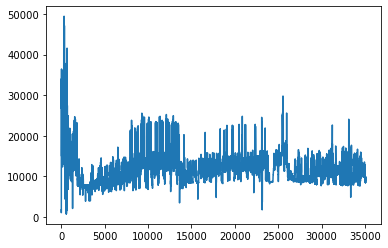

In [14]:
train['Label2'].plot()

<AxesSubplot:>

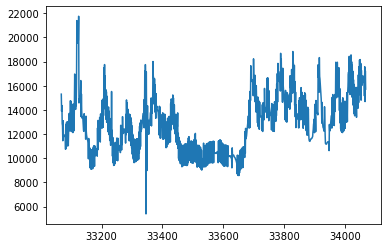

In [26]:
train['Label1'][-2000:-1000].plot()

In [22]:
predict_res = pd.read_csv("./res/merge_res.csv")

<AxesSubplot:>

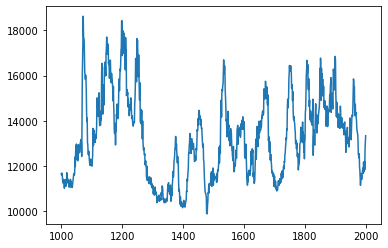

In [23]:
predict_res['Label1'][1000:2000].plot()

<AxesSubplot:>

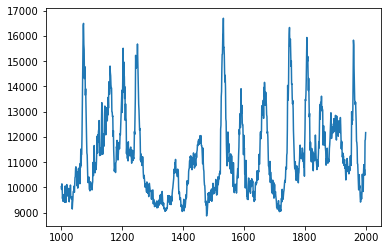

In [24]:
predict_res['Label2'][1000:2000].plot()

# 通过训练找出在训练集和测试集中差别很大的样本

In [5]:
from sklearn.model_selection import train_test_split
train['is_test'] = 0
test['is_test'] = 1
data_v2 = pd.concat([train, test]).reset_index(drop=True)
for f in features:
    if f not in ['weekday','hour', 'ts']:
        q = len(data_v2[f].drop_duplicates())
        data_v2[f] = pd.qcut(data_v2[f], q=int(q/10), labels=False, duplicates="drop")

In [35]:
import lightgbm as lgb
features_list = [ 'JS_NH3', 'CS_NH3', 'JS_TN', 'CS_TN', 'JS_LL', 'MCCS_NH4', 'MCCS_NO3', 'JS_COD', 'CS_COD', 'JS_SW', 'CS_SW', 'B_HYC_NH4', 'B_HYC_XD', 'B_HYC_MLSS', 'B_HYC_JS_DO', 'B_HYC_DO', 'B_CS_MQ_SSLL', 'B_QY_ORP', 'N_HYC_NH4', 'N_HYC_XD', 'N_HYC_MLSS', 'N_HYC_JS_DO', 'N_HYC_DO', 'N_CS_MQ_SSLL']

feature_score_dict = {}
for i in range(len(features_list)-1):
    for j in range(i+1, len(features_list)):
        features_filter = ['ts', 'weekday', features_list[i], features_list[j]]
        X_train, X_test, y_train, y_test  = train_test_split(data_v2[features_filter], data_v2['is_test'], test_size=0.2)
        model = lgb.LGBMClassifier(
                boosting="gbdt",
                max_depth=4,
                learning_rate=0.005,
                n_estimators=500,
                min_child_weight=1,
                min_data_in_leaf=60,
                subsample = 0.7,
                feature_fraction=0.4,
                bagging_seed=1,
                reg_alpha=0.11,
                reg_lambda=0.1,  # 此处不改了
                min_sum_hessian_in_leaf=0.01,
                random_state=1212
            )
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=['auc'],
                  early_stopping_rounds=20, verbose=200)
        feature_score_dict[f'{features_list[i]}_{features_list[j]}_score'] = model.best_score_['valid_1']['auc']



Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.914279	training's binary_logloss: 0.244945	valid_1's auc: 0.914613	valid_1's binary_logloss: 0.236584
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.832604	training's binary_logloss: 0.243682	valid_1's auc: 0.833476	valid_1's binary_logloss: 0.244227
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.806647	training's binary_logloss: 0.243599	valid_1's auc: 0.807501	valid_1's binary_logloss: 0.244905
Training until validation scores don't improve for 20 rounds
[200]	training's auc: 0.84489	training's binary_logloss: 0.218853	valid_1's auc: 0.844263	valid_1's binary_logloss: 0.216404
Early stopping, best iteration is:
[248]	training's auc: 0.848823	training's binary_logloss: 0.214614	valid_1's auc: 0.848204	valid_1's binary_logloss: 0.

In [36]:
feature_score_dict

{'0_1_score': 0.9146133339033203,
 '0_2_score': 0.8334757336128192,
 '0_3_score': 0.8075012572336951,
 '0_4_score': 0.8482041123900227,
 '0_5_score': 0.8605937648644648,
 '0_6_score': 0.8269675881888454,
 '0_7_score': 0.7944719873790644,
 '0_8_score': 0.8219653717016966,
 '0_9_score': 0.9314273649049305,
 '0_10_score': 0.9995971595485521,
 '0_11_score': 0.8775321305671892,
 '0_12_score': 0.8333084239524641,
 '0_13_score': 0.8383379934928322,
 '0_14_score': 0.9458494714888986,
 '0_15_score': 0.7602396114786669,
 '0_16_score': 0.7972338476700016,
 '0_17_score': 0.9569116333285878,
 '0_18_score': 0.8242997823747145,
 '0_19_score': 0.8426332592978709,
 '0_20_score': 0.8751303971735307,
 '0_21_score': 0.9672422953007738,
 '0_22_score': 0.8115965141522538,
 '0_23_score': 0.7782246185373517,
 '1_2_score': 0.9078771306668041,
 '1_3_score': 0.9113323822525211,
 '1_4_score': 0.9254062304179766,
 '1_5_score': 0.9660521833738287,
 '1_6_score': 0.9347067685924962,
 '1_7_score': 0.9106911363039296,
